# Example: Binomial Lattice Models of Equity Share Price

## Background
A binomial lattice model assumes that each discrete time increment, the state of the system, e.g., the share price of equity, the short rate, etc., can either increase by a factor $u$ with probability $p$ or decrease by a factor $d$ with probability $(1-p)$. 

<div>
    <center>
        <img src="figs/Fig-Binomial-Lattice-Schematic.png" width="300"/>
    </center>
</div>

Different models can be developed to compute the tuple $(u,d,p)$. However, for now, let's use historical data to learn typical values governing the price movement. Thus, we’ll take an approach similar to the short-rate calculations discussed previously. 

## Learning Objectives
The objective of this example is to familiarize students with the application of simple probability mass functions to predict future uncertain quantities such as commodity prices, equity share prices, interest rates, etc. In particular, in this example, we will:

* __Objective 1__: Estimate typical values for the tuple $(u,d,p)$ using historical data for different the share price of different firms.  
* __Objective 2__: Compare bionomial lattice model simulations of share price, and statistical properties of the return, versus historical data 

## Setup
We set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions that we will use in the exercise, and custom types to model the components of our example problem.

### Packages
Fill me in.

### Types
Fill me in.

### Functions
Fill me in.

In [1]:
include("Include.jl");

  Activating project at `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-132/module-1`


## Prerequisite: Test the lattice model
Let’s start by calculating the hypothetical share price from an example (reproduced from Chapter 13 of Hull) before diving into historical data analysis. The lattice in this example has three levels (`L=0,1,2`), with an initial share price of $S_{\circ}=20.0$ USD. An `up` move has a probability of `p = 0.6523` and a magnitude of `u = 1.1`, while a `down` move has a magnitude of  `d = 0.9`.

### Implementation
Calculating the future share price with a binomial lattice requires setting the model’s parameters, including the initial share price (as a `Float64`), the number of time steps to simulate into the future, which equals the number levels of the tree starting from zero (as an `Int64`), the up and down move magnitudes (as `Float64` values), and the probability of an up move (as a `Float64`):

In [2]:
Sₒ,T,u,d,p = 20.0,2,1.1,0.9,0.6523;

Once these values are set, we use the `build(…)` function to create an empty lattice model of type `MyBinomialEquityPriceTree`, which is then passed to the `populate(…)` function using the [Julia piping operator](https://docs.julialang.org/en/v1/manual/functions/#Function-composition-and-piping) `|>`. The `populate(…)` function calculates the prices and probabilities of each node (type `MyBiomialLatticeEquityNodeModel`) in the tree:

In [3]:
test_model = build(MyBinomialEquityPriceTree, (
        u = u, d = d, p = p)) |> (x-> populate(x, Sₒ, T));

Finally, we compare the price values we calculated to those reported by Hull using the [PrettyTables.jl](https://github.com/ronisbr/PrettyTables.jl) package. We populate the `hull_price_dictionary` dictionary with the price values at each node, and compare those to our values. We populate the `prereq_data_table` array using a `for` loop, then use the `pretty_table(...)` function to display the table:

In [4]:
number_of_nodes = length(test_model.data);
prereq_data_table = Array{Any,2}(undef,number_of_nodes,3)
prereq_header_table = (["Index","Hull","This study"], ["","USD/share", "USD/share"]);
hull_price_dictionary = Dict(0=>20.0, 1=>22.0,2=>18.0,3=>24.2,4=>19.8,5=>16.2);
for i ∈ 0:(number_of_nodes-1)
    prereq_data_table[i+1,1] = i
    prereq_data_table[i+1,2] = hull_price_dictionary[i]
    prereq_data_table[i+1,3] = test_model.data[i].price
end

pretty_table(prereq_data_table,header=prereq_header_table, tf=tf = tf_html_default)

Index,Hull,This study
,USD/share,USD/share
0,20.0,20.0
1,22.0,22.0
2,18.0,18.0
3,24.2,24.2
4,19.8,19.8
5,16.2,16.2


## Objective 1: Estimate the up, down and probability of an up move from data
After validating our lattice implementation, it's time to utilize historical data to compute a share price prediction. To create a binomial lattice model for future share prices, we need to model or estimate three critical parameters: $p$, $u$, and $d$.

* The $p$ parameter represents the probability of a share price increase or an `up` move between two periods $j\rightarrow{j+1}$. As a binary lattice model only allows `up` and `down` moves, the probability of a `down` move is $1-p$.
* The $u$ parameter represents the amount of an `up` move. If $S_{j}$ stands for the share price in period $j$, and $S_{j+1}$ is the share price in the next period, then an `up` move will give $S_{j+1} = u\cdot{S}_{j}$.
* The $d$ parameter represents the amount of a `down` move. If $S_{j}$ stands for the share price in period $j$, and $S_{j+1}$ is the share price in the next period, then a `down` move will give $S_{j+1} = d\cdot{S}_{j}$.

To estimate the $(u,d,p)$ parameters, let's utilize the `loaddatafile(...)` function to load historical (deidentified) daily price datasets for firms that comprise the S&P 500, which we've labeled as `Firm-1,...` for five consective years `Year-1` through `Year-5`. 

### Load the historical dataset
Let’s begin by specifying the index of the firm that we want to model. Please input the index of the desired firm in the `firm_index` variable. The `firm_index` variable is an `Int` value, e.g., `1`:

In [5]:
firm_index = 6;

Next, load the data files corresponding to `firm_index` for `Year-1 ... Year-5` using the `loaddatafile(...)` function. This function returns a `DataFrame` holding a years worth of data. Store each year in the `dataset` dictionary:

In [6]:
years = ["Year-1", "Year-2", "Year-3", "Year-4", "Year-5"];
dataset = Dict{String,DataFrame}();
for year ∈ years
    dataset[year] = loaddatafile(firm=firm_index, year=year);
end

Finally, combine all the annual firm specific `DataFrame` instances stored in `dataset` into a single `DataFrame` using the [append!](https://docs.juliahub.com/DataFrames/AR9oZ/0.21.5/lib/functions/#Base.append!) function. Store the combined `DataFrames` in the `df` variable:

In [7]:
df = dataset["Year-1"];
number_of_years = length(years);
for i ∈ 2:number_of_years
    year = years[i];
    append!(df, dataset[year])
end

### Estimate the `up`, `down` and probability `p`
Now, calculate the number of `up` and `down` moves, and the magnitude of these moves occuring in the dataset. To do this, let's assume a share price model of the form:

$$
S_{j} = \exp\left(\mu_{j,j-1}\Delta{t}\right)\cdot{S_{j-1}}
$$

where $\mu_{j,j-1}$ denotes the _return_ (units: 1/time) and $\Delta{t}$ (units: time) denotes the time step in the time period $j-1\rightarrow{j}$. Solving for the return $\mu_{j,j-1}$ gives the expression:

$$
\mu_{j,j-1} = \left(\frac{1}{\Delta{t}}\right)\cdot\ln\left(\frac{S_{j}}{S_{j-1}}\right)
$$

#### Implementation
Fill me in.

In [8]:
Δt = (1.0/365.0);
number_of_trading_days = nrow(df);
return_array = Array{Float64,1}(undef, number_of_trading_days-1)
for i ∈ 2:number_of_trading_days
    
    S₁ = df[i-1,:volume_weighted_average_price];
    S₂ = df[i,:volume_weighted_average_price];
    return_array[i-1] = (1/Δt)*log(S₂/S₁);
end

Using the `return_array`, compute the number of up moves which is indicated by $\mu_{j,j-1}>0$ and estimate the probability of an `up` move `p`:

In [9]:
N₊ = findall(x->x>0,return_array) |> length
p̄ = N₊/length(return_array);

Finally, let's compute the average magnitide of an `up` move: 

In [10]:
index_up_moves = findall(x->x>0, return_array);
uarray = Array{Float64,1}();
for index ∈ index_up_moves
    μ = return_array[index];
    push!(uarray, exp(μ*Δt))
end

ū = mean(uarray);

and the average magnitude of a `down` move:

In [11]:
index_down_moves = findall(x->x<0, return_array);
darray = Array{Float64,1}();
for index ∈ index_down_moves
    μ = return_array[index];
    push!(darray,exp(μ*Δt));
end

d̄ = mean(darray);

### Build binomial lattice model using historial $(u,d,p)$ parameters
Now that we have values for the $(u,d,p)$ tuple, let's build an instance of the `MyBinomialEquityPriceTree` type, and store it in the variable `model`. First, let's set a value of price per share at the root of the tree in the variable `Sₒ`, then set the number of days forward we want to simulate, and store this value in the `T` variable:

In [12]:
T = 21;
start_index = 820
stop_index = start_index + T
Sₒ = df[start_index,:volume_weighted_average_price];

then build an instance of the `MyBinomialEquityPriceTree` type using the `build` function, populate the tree using the [Julia piping operator](https://docs.julialang.org/en/v1/manual/functions/#Function-composition-and-piping) `|>` and the `populate(...)` function and store in the `model` variable:

In [13]:
model = build(MyBinomialEquityPriceTree, (
    u = ū, d = d̄, p = p̄)) |> (x-> populate(x, Sₒ, T));

## Objective 2: Lattice model versus historical price data
Let’s compare the share price simulation data with the actual market data for Firm `firm_index`. To do this, we create and populate the `simulation_data_array` array which holds the actual [VWAP price](https://en.wikipedia.org/wiki/Volume-weighted_average_price) which we compare to the expected price and uncertainty computed by the latticre model.

### Populate the simulation array
Create the `simulation_data_array` that is `T` $\times$ `4` in size. We populate this array using a `for` loop, iterating over the trading days `0…T`. During each pass of the loop, we’ll populate the columns of the `simulation_data_array`. The first column contains the trading day index, and the second column holds the observed [VWAP price](https://en.wikipedia.org/wiki/Volume-weighted_average_price) from `df`. The third column is the expected price computed over the lattice for trading data index `i` using the `𝔼(model,level=i)` function, and the fourth column holds the lattice predicted standard deviation of the [VWAP price](https://en.wikipedia.org/wiki/Volume-weighted_average_price)  computed by calling the `𝕍(model,level=i) |> sqrt` function for trading day index `i`:

In [14]:
simulation_data_array = Array{Float64,2}(undef, T, 4);
for i ∈ 0:(T-1)
    simulation_data_array[i+1,1] = i+start_index
    simulation_data_array[i+1,2] = df[start_index+i,:volume_weighted_average_price]
    simulation_data_array[i+1,3] = 𝔼(model,level=i);
    simulation_data_array[i+1,4] = 𝕍(model,level=i) |> sqrt;
end

### Visualize
To display the `simulation_data_array`, we utilize the `plot(…)` function from the [Plots.jl](https://github.com/JuliaPlots/Plots.jl) package. Our focus is on presenting the anticipated stock price and its corresponding uncertainty, which we derive from the lattice model, on the y-axis. On the x-axis, we plot the trading index. Additionally, we include the observed [VWAP price](https://en.wikipedia.org/wiki/Volume-weighted_average_price) on the same axis:

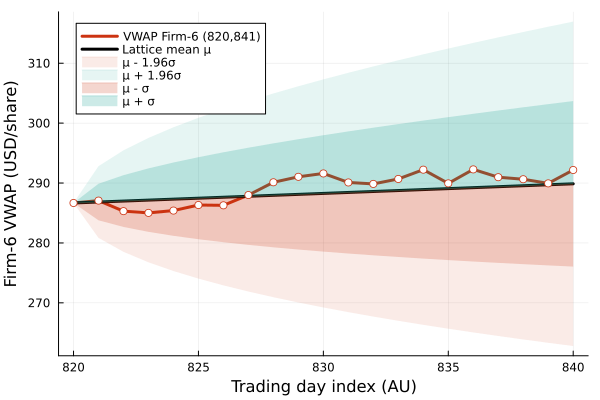

In [15]:
L68 = simulation_data_array[:,3] .- simulation_data_array[:,4]
U68 = simulation_data_array[:,3] .+ simulation_data_array[:,4]
L95 = simulation_data_array[:,3] .- 1.96*simulation_data_array[:,4]
U95 = simulation_data_array[:,3] .+ 1.96*simulation_data_array[:,4]

plot(simulation_data_array[:,1],simulation_data_array[:,2], c=colors[5], lw=3,label="VWAP Firm-$(firm_index) ($(start_index),$(stop_index))", legend=:topleft)
plot!(simulation_data_array[:,1],simulation_data_array[:,3], c=:black, lw=3, label="Lattice mean μ")
plot!(simulation_data_array[:,1],simulation_data_array[:,3], fillrange=L95, alpha=0.1, c=colors[5], label="μ - 1.96σ")
plot!(simulation_data_array[:,1],simulation_data_array[:,3], fillrange=U95, alpha=0.1, c=colors[6], label="μ + 1.96σ")
plot!(simulation_data_array[:,1],simulation_data_array[:,3], fillrange=L68, alpha=0.20, c=colors[5], label="μ - σ")
plot!(simulation_data_array[:,1],simulation_data_array[:,3], fillrange=U68, alpha=0.20, c=colors[6], label="μ + σ")
scatter!(simulation_data_array[:,1],simulation_data_array[:,2], msc=colors[5], mc=:white, label="")
xlabel!("Trading day index (AU)",fontsize=18)
ylabel!("Firm-$(firm_index) VWAP (USD/share)",fontsize=18)